In this notebook we construct a function to simulate images of lenses consisting of an EPL and Sersic. It's *nearly* as simple as possible: the one complexity is that the image is first simulated on a fine grid and then downsampled to the target one.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from math import pi

import functorch
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.lenses import EPL, Point
from caustic.sources import Sersic
from caustic.utils import get_meshgrid


DEVICE = "cpu"

Define image grid

In [3]:
fov = 5.0
n_pix = 50
res = fov / n_pix

Create fine grid used in `simulate()`

In [4]:
upsample_factor = 4
_thx_fine, _thy_fine = get_meshgrid(
    res / upsample_factor, upsample_factor * n_pix, upsample_factor * n_pix, DEVICE
)

Actual image grid for later use

In [5]:
thx, thy = get_meshgrid(res, n_pix, n_pix, DEVICE)

Fix lens and source models, redshifts, cosmology and noise level

In [6]:
lens = EPL(DEVICE)
src = Sersic(DEVICE)
z_l = torch.tensor(0.5, device=DEVICE)
z_s = torch.tensor(2.1, device=DEVICE)
cosmology = FlatLambdaCDMCosmology()
sigma_n = torch.tensor(20.0)

Define `simulate()` function

In [7]:
def simulate(x_lens, x_src):
    """
    Args:
        x_lens: tensor of lens arguments.
        x_src: tensor of source arguments.
    """
    # Ray-trace
    beta_x, beta_y = lens.raytrace(
        _thx_fine, _thy_fine, z_l, z_s, cosmology, *x_lens
    )
    # Evaluate source
    mu_fine = src.brightness(beta_x, beta_y, *x_src)
    # Downsample
    mu = F.avg_pool2d(mu_fine[None, None, :, :], upsample_factor)[0, 0]
    # Add noise
    return mu + sigma_n * torch.randn_like(mu)

Fix lens and source parameters and simulate

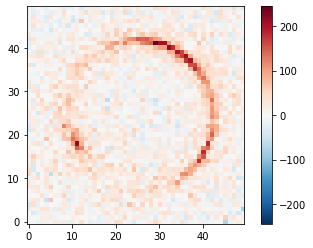

In [8]:
# EPL args: thx0, thy0, q, phi, b, t
x_lens = torch.tensor([0.0, 0.0, 0.8, pi/6, 1.5, 1.1], device=DEVICE)
# Sersic args: thx0, thy0, q, phi, index, th_e, I_e
x_src = torch.tensor([0.13, 0.04, 0.6, pi/4, 4.0, 2.5, 1.0], device=DEVICE)

# Simulate!
mu = simulate(x_lens, x_src)

# Plot
plt.imshow(mu, cmap="RdBu_r", vmin=-mu.abs().max(), vmax=mu.abs().max(), origin="lower")
plt.colorbar()

Since our lensing model is differentiable, we can compute the magnification with automatic differentiation

In [9]:
from caustic.lenses.utils import get_magnification

In [10]:
_mag_fine = get_magnification(
    lens.raytrace, _thx_fine, _thy_fine, z_l, z_s, cosmology, *x_lens
)
mag = F.avg_pool2d(_mag_fine[None, None, :, :], upsample_factor)[0, 0]

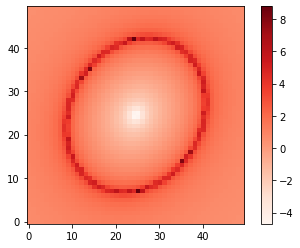

In [11]:
plt.imshow(mag.log(), origin="lower", cmap="Reds")
plt.colorbar()

We can batch over a bunch of point mass lenses

In [12]:
lens = Point()

In [15]:
n_pts = 100
thx0s = fov * (torch.rand(n_pts) - 0.5)
thy0s = fov * (torch.rand(n_pts) - 0.5)
th_eins = 0.5 * torch.randn(n_pts).abs()

in_dims = 5 * (None,) + 3 * (0,)
raytrace_vmap = functorch.vmap(lens.raytrace, in_dims=in_dims)

# Plumbing
def raytrace_vmap(get_alpha, thx, thy, z_l, z_s, cosmology, *args, **kwargs):
    n_args = len(args) + len(kwargs)
    in_dims = 5 * (None,) + n_args * (0,)
    axs, ays = functorch.vmap(get_alpha, in_dims=in_dims)(
        thx, thy, z_l, z_s, cosmology, *args, **kwargs
    )
    bx = thx - axs.sum(0)
    by = thy - ays.sum(0)
    return bx, by

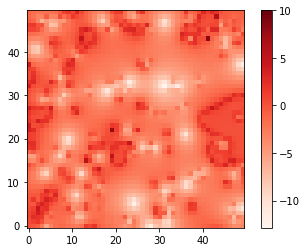

In [26]:
n_pts = 100
thx0s = fov * (torch.rand(n_pts) - 0.5)
thy0s = fov * (torch.rand(n_pts) - 0.5)
th_eins = 0.5 * torch.randn(n_pts).abs()

_mag_fine = get_magnification(
    partial(raytrace_vmap, lens.alpha),
    _thx_fine,
    _thy_fine,
    z_l,
    z_s,
    cosmology,
    thx0s,
    thy0s,
    th_eins,
)
mag = F.avg_pool2d(_mag_fine[None, None, :, :], upsample_factor)[0, 0]

plt.imshow(mag.log(), origin="lower", cmap="Reds", vmax=10)
plt.colorbar()